# RSS Feeds Sentiment Analysis Notebook

### Collection and Sentiment analysis of rss feed articles from News broadcasters
Code to collect data from 5 News RSS Feeds.
- BBC
- NY Times
- CBS News
- Aljazeera
- The Guardian

In [49]:
import joblib
import pickle
import os,re
import requests
import xml.etree.ElementTree as ET
import pandas as pd
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import HashingVectorizer

In [3]:
def get_newsfeed(url, broadcast):
    response = requests.get(url)
    xml_content = response.content
    root = ET.fromstring(xml_content)
    
    items = []
    for item in root.findall(".//item"):
        news_item = {
            'title': item.find('title').text if item.find('title') is not None else '',
            'pubDate': item.find('pubDate').text if item.find('pubDate') is not None else '',
            'link': item.find('link').text if item.find('link') is not None else '',
            'description': item.find('description').text if item.find('description') is not None else '',
            'broadcast': broadcast
        }
        items.append(news_item)
    
    return pd.DataFrame(items)

In [264]:
def preprocess_text(df, column_name='title'):
    df_preprocessed = df.copy()
    
    df_preprocessed[f'clean_{column_name}'] = df_preprocessed[column_name].str.lower()
    
    df_preprocessed[f'clean_{column_name}'] = df_preprocessed[f'clean_{column_name}'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
    
    stop_words = set(stopwords.words('english'))
    df_preprocessed[f'clean_{column_name}'] = df_preprocessed[f'clean_{column_name}'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    
    df_preprocessed[f'{column_name}_tokens'] = df_preprocessed[f'clean_{column_name}'].apply(word_tokenize)
    
    stemmer = PorterStemmer()
    df_preprocessed[f'stemmed_{column_name}'] = df_preprocessed[f'{column_name}_tokens'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x]))
    
    lemmatizer = WordNetLemmatizer()
    df_preprocessed[f'{column_name}_lemma'] = df_preprocessed[f'{column_name}_tokens'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x]))
    
    return df_preprocessed

# Sentiment Analysis for the collected datasets

In [11]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd
import os
from datetime import date

# New Broadcasters Newsfeeds:
bbc_url = "http://feeds.bbci.co.uk/news/rss.xml"  
nytimes_url = "https://rss.nytimes.com/services/xml/rss/nyt/HomePage.xml"
cbsnews_url = "https://www.cbsnews.com/latest/rss/world"
aljazeera_url = "https://www.aljazeera.com/xml/rss/all.xml"
theguardian_url = "https://www.theguardian.com/uk/rss"

url_linkers = [
    (bbc_url, "BBC"),
    (nytimes_url, "NYC Times"),
    (cbsnews_url, "CBS News"),
    (aljazeera_url, "Aljazeera"),
    (theguardian_url, "The Guardian")
]

all_news = []
for url, broadcast in url_linkers:
    print(f"News feed from: {broadcast}")
    df_url = get_newsfeed(url, broadcast)
    cnt = len(df_url)
    print(f"Collected Articles: {cnt}")
    all_news.append(df_url)

df_combined = pd.concat(all_news, ignore_index=True)
print(f"\nTotal articles collected: {len(df_combined)}")

hashing_vectorizer_config = joblib.load('hashing_vectorizer_config.pkl')
vectorizer = HashingVectorizer(n_features=hashing_vectorizer_config['n_features'])
model = joblib.load('logistic_regression_model.pkl')

#Title Sentiment Calculation
df_combined_preprocessed = preprocess_text(df_combined, column_name='title')
df_X = df_combined_preprocessed['title_lemma'] 
X_vectorized_new = vectorizer.transform(df_X)
y_pred_new = model.predict(X_vectorized_new)
df_combined['title_predicted_sentiment'] = y_pred_new

#Description Sentiment Calculation
df_combined_preprocessed = preprocess_text(df_combined, column_name='description')
df_X = df_combined_preprocessed['description_lemma'] 
X_vectorized_new = vectorizer.transform(df_X)
y_pred_new = model.predict(X_vectorized_new)
df_combined['description_predicted_sentiment'] = y_pred_new

# Save the combined DataFrame to a CSV file
folder_path = "C:/Users/ab/OneDrive/Desktop/DS and Eng Methods Fall 24 (Sem 1)/dataset"
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

if csv_files:
    old_data_df = pd.concat([pd.read_csv(os.path.join(folder_path, file)) for file in csv_files], ignore_index=True)
    updated_data_df = pd.concat([old_data_df, df_combined], axis=0)
    latest_feed_data_df = updated_data_df.drop_duplicates()
else:
    latest_feed_data_df = df_combined

cnt = len(latest_feed_data_df)
today = date.today()
print(f"Loading data with total dataset of: {cnt}")
latest_feed_data_df.to_csv(os.path.join(folder_path, f"{today}.csv"), index=False)

News feed from: BBC
Collected Articles: 36
News feed from: NYC Times
Collected Articles: 24
News feed from: CBS News
Collected Articles: 30
News feed from: Aljazeera
Collected Articles: 25
News feed from: The Guardian
Collected Articles: 118

Total articles collected: 233
Loading data with total dataset of: 39685


In [17]:
latest_feed_data_df[['title','title_predicted_sentiment']].tail()

,title,title_predicted_sentiment
213,"Hurricanes, the Middle East, and Covid-19 test...",Neutral
215,Tories choose between Badenoch and Jenrick. Pl...,Neutral
216,‘I am your retribution’: Trump’s radical plan ...,Neutral
218,‘We’ve been dehumanised’: how the US immigrati...,Neutral
219,Can Kamala Harris defeat Trump’s election lies...,Negative


# Distribution of Dataset Articles by Broadcaster

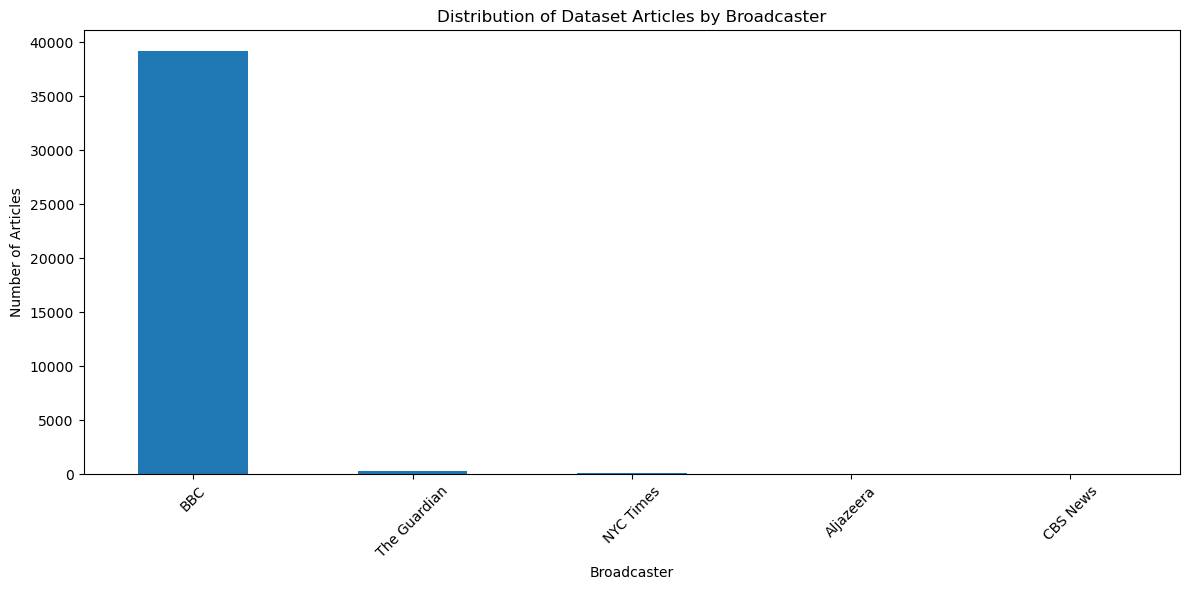

broadcast
BBC             39135
The Guardian      350
NYC Times          81
Aljazeera          67
CBS News           52
Name: count, dtype: int64


In [67]:
rss_article_counts = latest_feed_data_df['broadcast'].value_counts()
plt.figure(figsize=(12, 6))
rss_article_counts.plot(kind='bar')
plt.title('Distribution of Dataset Articles by Broadcaster')
plt.xlabel('Broadcaster')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print(rss_article_counts)

**Observation** :
- The dataset originally came from the BBC, which is reflected in the article counts, leading to heavily skewed trends. The majority of the datasets consistd of BBC articles.
- However, by configuring the notebook to be self-updating and by adding additional RSS feeds, the dataset could be expanded to collect more diverse source
- Continue collecting data from all configured RSS feeds to increase diversity.s.

# Histogram of Publication Times

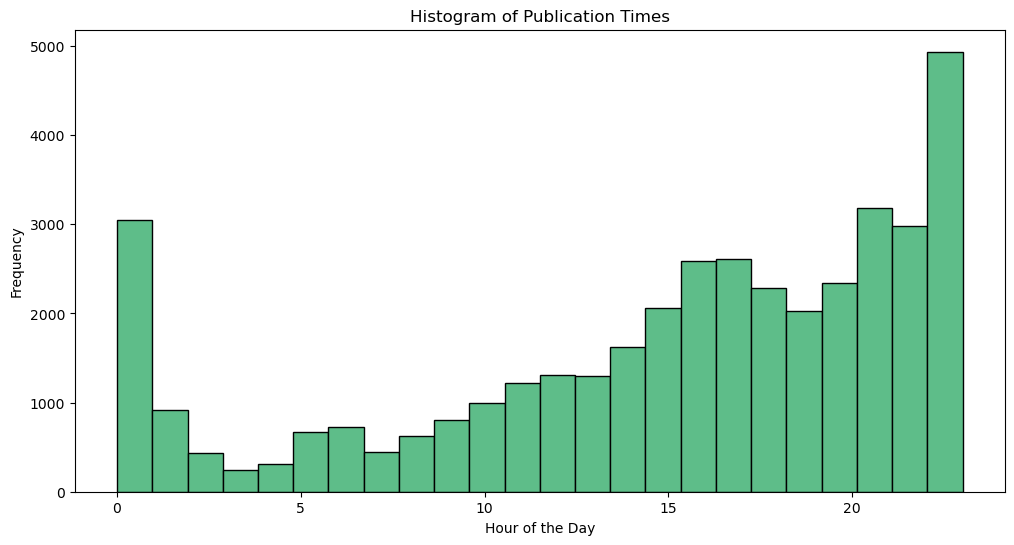

In [224]:
latest_feed_data_df = latest_feed_data_df.copy()
latest_feed_data_df.loc[:, 'pubDate'] = pd.to_datetime(latest_feed_data_df['pubDate'], format='mixed', utc=True)
latest_feed_data_df['hour'] = latest_feed_data_df['pubDate'].dt.hour

plt.figure(figsize=(12, 6))
plt.hist(latest_feed_data_df['hour'], bins=24, color='#5EBD89', edgecolor='black')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.title('Histogram of Publication Times')
plt.show()

**Observations:**
- Peak publishing hours appear to be in the morning and early afternoon

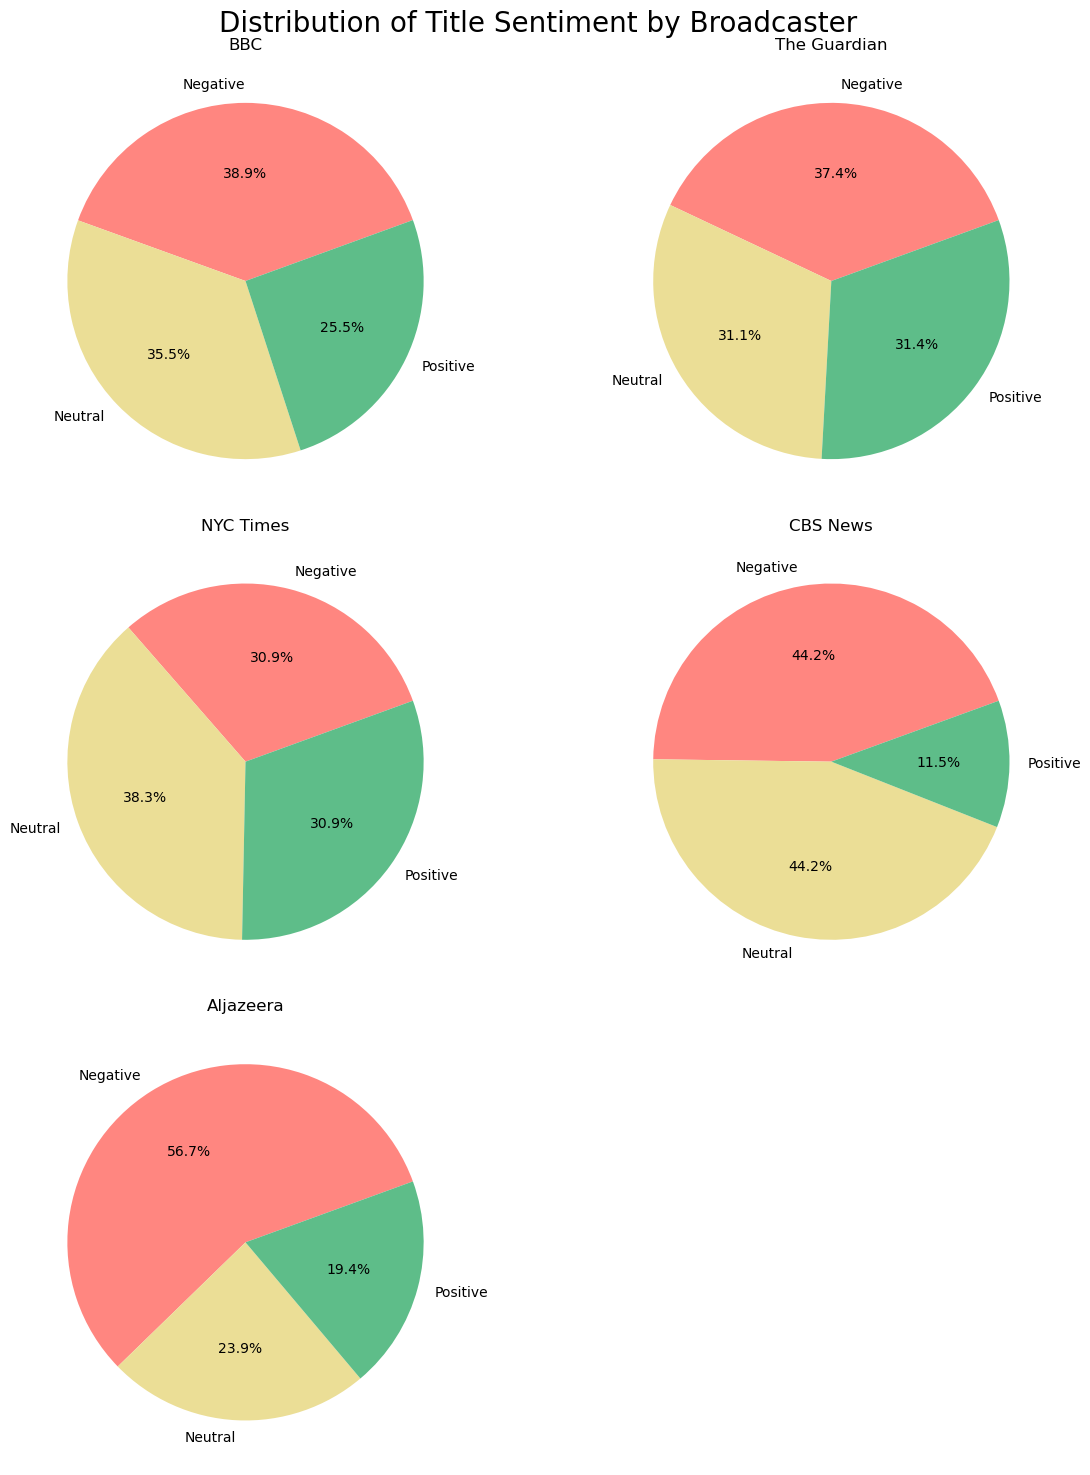

In [222]:
broadcasters = latest_feed_data_df['broadcast'].unique()
color_map = {
    'Positive': '#5EBD89',  # Green
    'Negative': '#FF8680',  # Red
    'Neutral': '#EBDE96'    # Yellow
}
fig, axes = plt.subplots(nrows=(len(broadcasters)+1)//2, ncols=2, figsize=(12, 5*((len(broadcasters)+1)//2)))
fig.suptitle('Distribution of Title Sentiment by Broadcaster', fontsize=20)
axes = axes.flatten()

for i, broadcaster in enumerate(broadcasters):
    broadcaster_data = latest_feed_data_df[latest_feed_data_df['broadcast'] == broadcaster]
    sentiment_counts = broadcaster_data['title_predicted_sentiment'].value_counts()
    for sentiment in color_map.keys():
       if sentiment not in sentiment_counts.index:
           sentiment_counts[sentiment] = 0
    sentiment_counts = sentiment_counts.sort_index()
    colors = [color_map[sentiment] for sentiment in sentiment_counts.index]    
    axes[i].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=20, colors=colors)
    axes[i].set_title(f'{broadcaster}')
    
for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

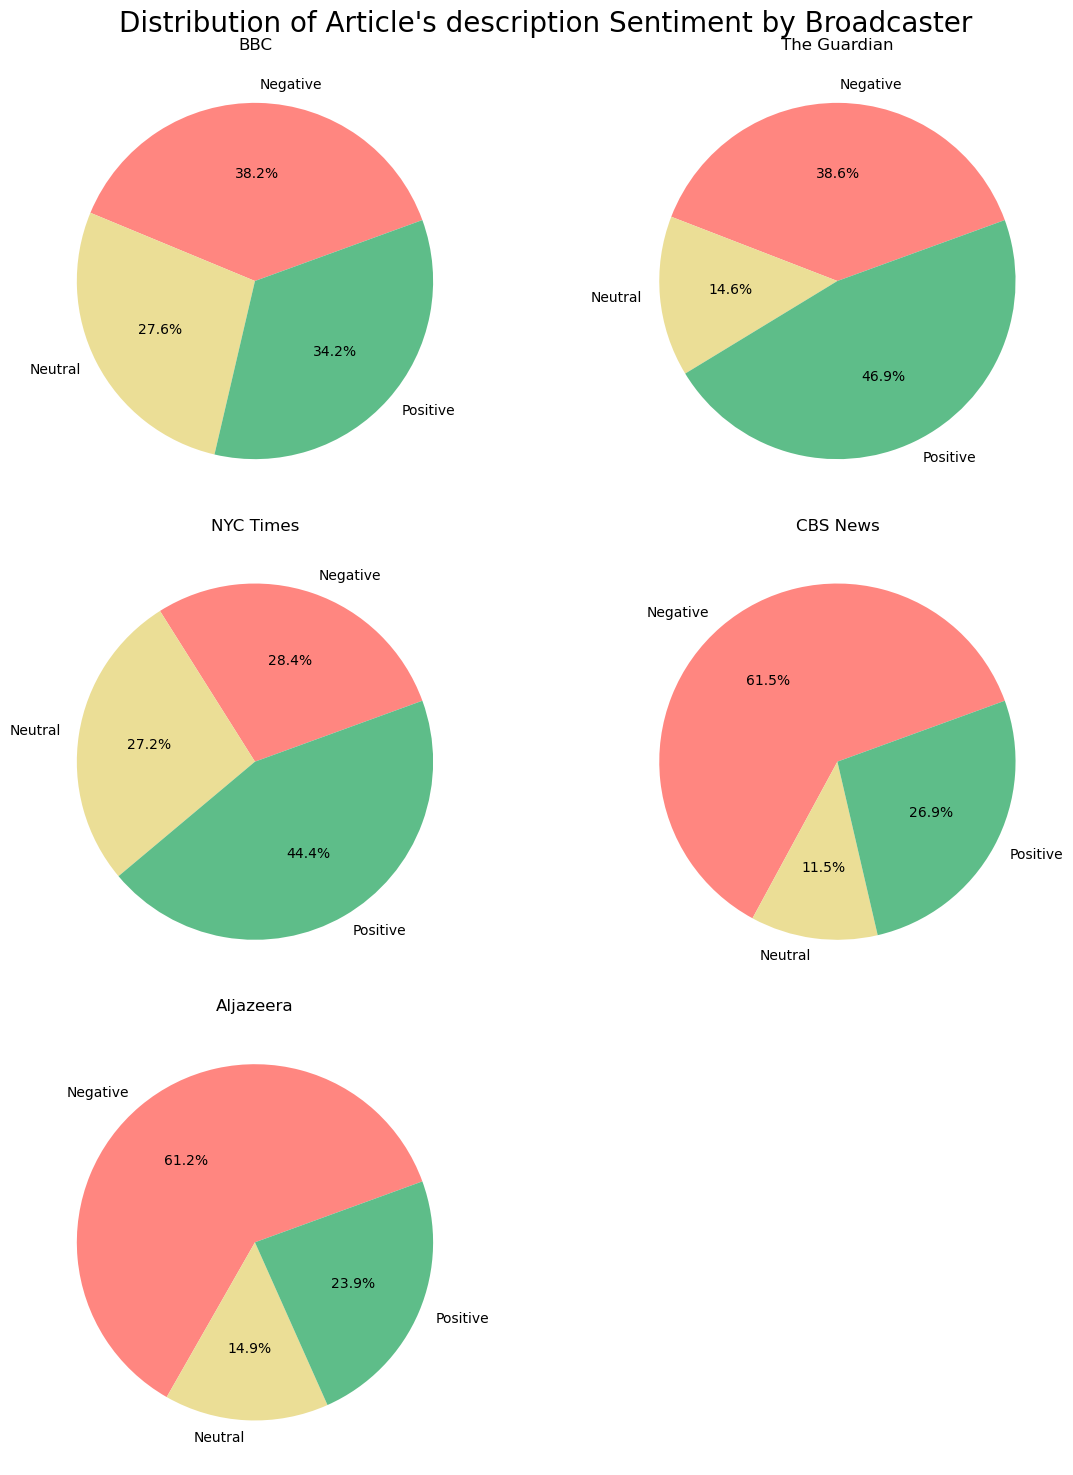

In [209]:
broadcasters = latest_feed_data_df['broadcast'].unique()
color_map = {
    'Positive': '#5EBD89',  # Green
    'Negative': '#FF8680',  # Red
    'Neutral': '#EBDE96'    # Yellow
}
fig, axes = plt.subplots(nrows=(len(broadcasters)+1)//2, ncols=2, figsize=(12, 5*((len(broadcasters)+1)//2)))
fig.suptitle("Distribution of Article's description Sentiment by Broadcaster", fontsize=20)
axes = axes.flatten()

for i, broadcaster in enumerate(broadcasters):
    broadcaster_data = latest_feed_data_df[latest_feed_data_df['broadcast'] == broadcaster]
    sentiment_counts = broadcaster_data['description_predicted_sentiment'].value_counts()
    for sentiment in color_map.keys():
        if sentiment not in sentiment_counts.index:
            sentiment_counts[sentiment] = 0
    sentiment_counts = sentiment_counts.sort_index()
    colors = [color_map[sentiment] for sentiment in sentiment_counts.index]
    axes[i].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=20, colors=colors)
    axes[i].set_title(f'{broadcaster}')
    
for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Observations** :
- For most broadcasters, neutral sentiment dominates in both titles and descriptions
- With visible, exceptions only being Aljazeera in both title and description and CBS in the description. 

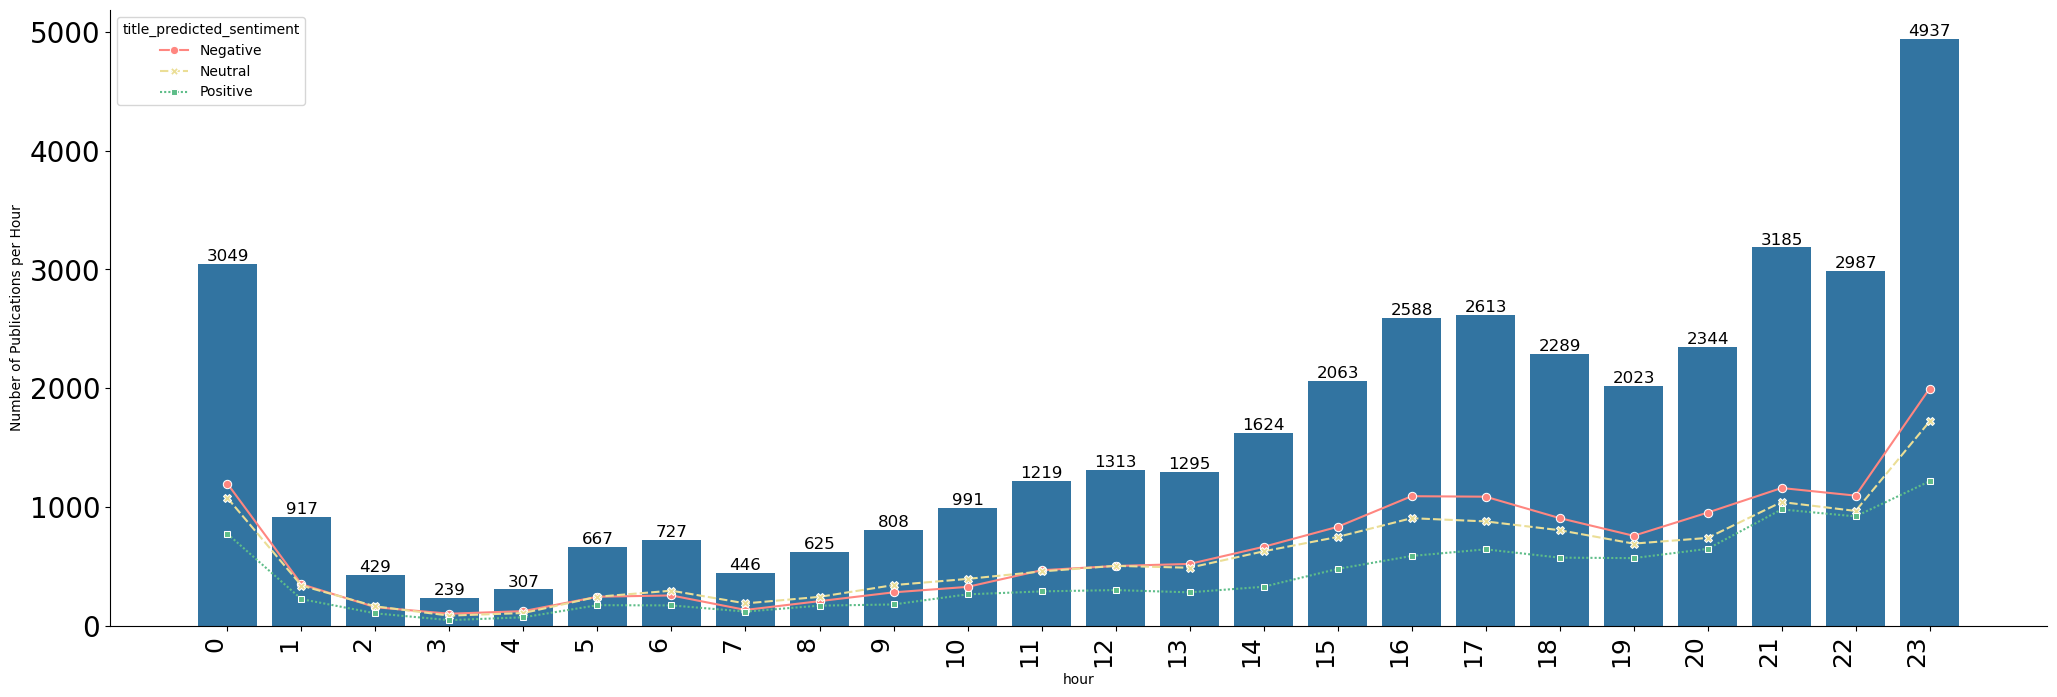

In [226]:
def publication_vs_time(plot_publications_by_time_unit, time):
    colors = {'Positive': '#5EBD89', 'Negative': '#FF8680', 'Neutral': '#EBDE96'}
    plt.figure(figsize=(25, 8))
    ax = sns.countplot(data=plot_publications_by_time_unit, x=time)
    plt.xticks(rotation=90, ha='right')
    plt.ylabel('Number of Publications per ' + time.capitalize())
    plt.xlabel(f'{time}')
    sns.despine(left=False, bottom=False)
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom',fontsize=12)
    sns.lineplot(data=plot_publications_by_time_unit.groupby(time)['title_predicted_sentiment'].value_counts().unstack().fillna(0), 
                 markers=True, ax=ax, palette=colors)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=20)
    plt.show()
publication_vs_time(latest_feed_data_df, 'hour')

### Most articals publishing timeline seem to either 1 am or 11 pm.

In [316]:
latest_feed_data_df['pubDate'] = pd.to_datetime(latest_feed_data_df['pubDate'])
df_sorted = latest_feed_data_df.sort_values('pubDate', ascending=False)
latest_articles = df_sorted.head(100)

df_sorted['description_wordcount'] = df_sorted['description'].apply(lambda x: len(str(x).split(" ")))
df_sorted['title_wordcount'] = df_sorted['title'].apply(lambda x: len(str(x).split(" ")))

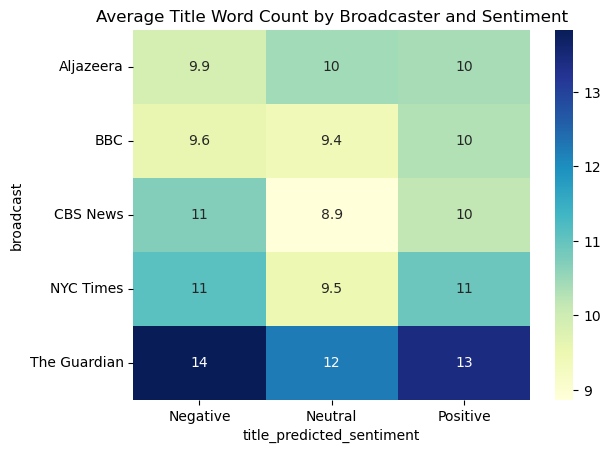

In [322]:
pivot_table = pd.pivot_table(df_sorted, values='title_wordcount', index='broadcast', columns='title_predicted_sentiment', aggfunc='mean')
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu')
plt.title('Average Title Word Count by Broadcaster and Sentiment')
plt.show()

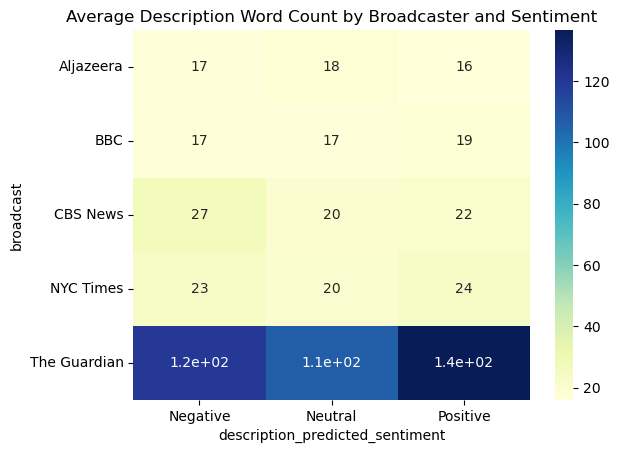

In [329]:
pivot_table = pd.pivot_table(df_sorted, values='description_wordcount', index='broadcast', columns='description_predicted_sentiment', aggfunc='mean')
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu')
plt.title('Average Description Word Count by Broadcaster and Sentiment')
plt.show()